# Group 27: Go Thymio!!

**Students: Cameron Bush,
Rayen Dhahri,
Séverin Bruno Konishi,
Noah Lugon-Moulin**


## Abstract

This final project represents a culmination of all of the topics covered during MICRO-452. The goal was to place a Thymio robot within an obstacle field, and use computer vision, path planning, global navigation, local navigation and state estimation to direct it to a goal. The first step of the process was to decide on the environment the Thymio would be placed within. We considered the examples provided from previous semesters, and eventually we decided on a simple white background with 3D colored blocks as obstacles.The intention was to have enough contrast between the obstacles and the background to allow an accurate contour detection. </br>The goal and the Thymio were both identified using ArUco marker detection. This allowed for an accurate tracking of both the position and orientation of the Thymio, which were integral in applying a global navigation framework based on computer vision. In this project, we were able to successfully perfom the global navigation **with and without** camera using the filtering, **avoid** the **obstacles** locally using sensor data, and ensure success in the event of a **kidnapping**.

Github repository: https://github.com/Heatdh/mobile_robotics

# Contents
- ### [Environment](##env)
- ### [Computer Vision](##vision)
- ### [Path planning](##planning)
- ### [Filtering](##kalman)
- ### [Control](##cont)
- ### [Local Navigation](##obst)
- ### [Run the experiment](##run)
- ### [Conclusion](##conc)
- ### [References](##ref)

## Environment  <a class="anchor" id="env"></a>


The experiment environment is composed of the following components: 
- White background with 3D colored blocks as obstacles
- ArUco markers for Thymio localisation and goal identification
- Unexpected obstacle placed during navigation </br> </br>
![environment](report_figures/env.jpg)


### Setting Up your python environment 
To start please make sure you select the kernel environment, where you have installed or where you will be installing the dependencies of the project. </br>
You can also install them from the notebook


In [ ]:
#!pip install -r requirements.txt

In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
import cv2
from cv2 import aruco
from matplotlib import pyplot as plt
import math
from math import atan2, cos, sin, sqrt, pi
import numpy as np
from sympy import Segment, Point, Ray, Polygon
import time

## Preparing the testing framework
In order to display the results of each component of our project, we capture an image before performing the obstacle detection and the path planning. Note that in the real test/ benchmark we do capture images live from the camera and lock it to specific number of frames per seconds

In [4]:
# init camera
camera = cv2.VideoCapture(0)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
# Grab a single frame of video
ret, img = camera.read()
# close camera
camera.release()

### GET INITIAL POSITION, GOAL AND OBSTACLE POSITIONS

imgResult = img.copy()

## Computer Vision  <a class="anchor" id="vision"></a>
### Extracting main Vision Componnents
We implemented 3 different functions to extract key vision elements from a frame:  
- The **get_obstacle_position**:  detects the obstacle position and enlarges them in proportion with the thymio radius.
    - Here, we use a calibration function to define the colors of the masks we are applying by varying the minimum and maximum of each of our color channels until only the obstacles are visible.
    - We perform a median blur to remove the noise and expand the vertices with the thymio size to avoid collision </br>

- The **get_thymio_position** 
    - Here, we detect the Aruco marker on top of the thymio and output the center of thymio, its radius, its angle, or an error flag if the Thymio is not present in he frame. </br>

- The **get_goal_position** 
    - Detects Aruco goal marker and returns the position of the goal. </br>
    
### Why aruco ? 
#### Introduction to Aruco markers
Each ArUco marker is square, has a large black border, and an inner binary matrix which is associated with a specific identifier in the Aruco dictionary. The detection of the markers occurs in two steps. </br>The first is to identify all square shapes that could be markers. Segmentation of the markers is achieved through adaptive thresholding, as each marker can be identified by their wide black border. Subsequently, contours are extracted, and any that do not approximate a square shape are discarded. After this initial detection, the identity of the markers must be determined by reading their respective bits.</br> The bits are separated into a binary white and black pattern by using Otsu Thresholding. Then, the image is divided into smaller cells, the number of which depend on the marker size and the thickness of the black border. </br> The number of black or white pixels within each of these cells are counted to determine if the entire bit is black or white. The last step is to analyze the bits which have now been identified as white or black, and determine if the marker is included within the Aruco dictionary. If it is, the corresponding ID is assigned to the marker, and the corner positions which are included in the dictionary are assigned to the image. </br>This allows the camera to read both position and orientation of each of the markers. </br> 

#### Compared to other methods
Initially, we tried to implement an approach to dectect both the thymio's and the goals positions by:
- First method: applying color masks and calculating the angle based on the contour. This approach posed the risk of a higher error for the true angle, and our Path navigation relied a lot on the angle of the thymio/vertice. 
- Second method: Building a thymio annotated dataset and retraining yolov5s to have a low inference time (i.e. fast enough to detect thymio). The results were good, but the yolov program output the coordinates of a boundary box, not an angle. Only using aruco were we able to detect both the angle and the exact position inside the frame. The annotations are done using https://www.makesense.ai

**Sources**

ArUco: https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html

Otsu Thresholding: http://www.labbookpages.co.uk/software/imgProc/otsuThreshold.html


In [5]:
def dist(pt1, pt2):
    ''' Returns the distance between 2 given points expressed as a list of len 2 '''
    distance = ( (pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2 )**0.5
    return distance

In [6]:
def get_thymio_position(img, img_output):
    
    '''
    Function that outputs Thymio position, radius and orientation from camera frames using Aruco marker detection
    Parts of code taken from https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html

    Inputs: - img : image from camera in BGR format
            - img_output : copy of image img on which will be drawn Thymio's contours (for visualization)

    Output: - center : tuple (x,y) representing the center of the Thymio (in pixels)
            - radius : radius of the Thymio (in pixels)
            - angle : orientation of the Thymio (in radians)
            - thymio_detected : boolean set to True if Thymio was detected, False if not
    '''
    
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    frame_markers = aruco.drawDetectedMarkers(img_output, corners, ids)
    
    
    thymio_detected = False
    center = (0,0)
    radius = 0
    angle = 0
    
    if np.all(ids != None):
        for i in range(len(ids)):
            if ids[i] == 0:
                thymio_detected = True
                c = corners[i][0]

                top_center = (c[0:2, 0].mean(),c[0:2, 1].mean())
                bottom_center = (c[2:4, 0].mean(), c[2:4, 1].mean())
                left_center = (c[0:4:3, 0].mean(), c[0:4:3, 1].mean())
                right_center = (c[1:3, 0].mean(), c[1:3, 1].mean())
                points = np.array([ [c[2,0],c[2,1]], [c[3,0],c[3,1]], [left_center[0],left_center[1]], [right_center[0],right_center[1]] ])

                square_center = (int(c[:, 0].mean()), int(c[:, 1].mean()))
                radius = int(max( dist(square_center,c[0]), dist(square_center,c[1]), dist(square_center,c[2]), dist(square_center,c[3])))
                angle = math.atan2(top_center[1]-bottom_center[1],top_center[0]-bottom_center[0])
                
                
                center = (int(points[:, 0].mean()), int(points[:, 1].mean()))
                cv2.arrowedLine(img_output, (center[0],center[1]), (int(top_center[0]),int(top_center[1])), (255,255,0), 10)
                cv2.circle(img_output,square_center,radius,(255,0,0),10)

                break

        
    return center, radius, angle, thymio_detected

In [7]:
def get_obstacle_position(img, thymio_radius, min_green = np.array([30, 80, 70]), max_green = np.array([70, 255, 150])):
    '''
    Function that outputs vertices of the obstacles (dilated by the Thymio's radius) for the visibility graph path planning
        Parts of code taken from :
        https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
        https://realpython.com/python-opencv-color-spaces/
        https://notebook.community/ricklon/opencvraspberrypi/notebook/openCV%20color%20detection
        
    Inputs: - img : image from camera in BGR format
            - thymio_radius : radius of Thymio in pixels (can be found with the get_thymio_position function)
            - min_green : minimum values for Hue, Saturation and Value for hsv mask
            - max_green : minimum values for Hue, Saturation and Value for hsv mask

    Output: - vertices : array (1 x nb_obstacles x 2) containing list of each obstacle's vertices
            - nb_obstacles : number of obstacles detected (after the dilatation)
            - x_max : length of the image img
            - y_max : width of the image img
    '''    

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv_blur = cv2.medianBlur(img_hsv, 15)
    mask = cv2.inRange(img_hsv_blur, min_green, max_green)
    mask = cv2.erode(mask, None, iterations=2) # 3x3 kernel used
    mask = cv2.dilate(mask, None, iterations=2)
    
    y_max, x_max = mask.shape

    # Expand obstacle size by the radius of the thymio
    dilatation_size = int(thymio_radius*1.2) # add security margin of 20% of thymio's radius
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2 * dilatation_size + 1,2 * dilatation_size + 1))
    mask_dilated = cv2.dilate(mask, kernel, iterations = 1)

    contours = cv2.findContours(mask_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2] # RETR_EXTERNAL to get external contour, CHAIN_APPROX_SIMPLE to get geometrical shape 

    output = cv2.bitwise_and(img, img, mask=mask)
    nb_obstacles = 0
    vertices = []
    if len(contours) != 0:
        contours = sorted(contours, key=lambda x:cv2.contourArea(x), reverse=True)
        for c in contours:
            area = cv2.contourArea(c)
            #print(area)
            if area > 1000:
                nb_obstacles += 1
                epsilon = 0.015*cv2.arcLength(c,True)
                approx = cv2.approxPolyDP(c,epsilon,True)
                cv2.drawContours(output, [approx], -1, (0, 255, 255), 20)
                vertices.append(approx)
            else: 
                break

    #plt.imshow(output)
    
    return vertices, nb_obstacles, x_max, y_max

In [8]:
def get_goal_position(img):
    '''
    Function that outputs goal position from initial camera frame
    Parts of code taken from https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html


    Inputs: - img : image from camera in BGR format

    Output: - goal_center : tuple (x,y) representing the center of the goal (in pixels)
            - goal_detected : boolean set to True if goal was detected, False if not
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    
    
    goal_detected = False
    goal_center = (0,0)
    goal_radius = 0
    
    if np.all(ids != None):
        for i in range(len(ids)):
            if ids[i] == 1:
                goal_detected = True
                c = corners[i][0]
                goal_center = (int(c[:, 0].mean()), int(c[:, 1].mean()))
                goal_radius = int(max( dist(goal_center,c[0]), dist(goal_center,c[1]), dist(goal_center,c[2]), dist(goal_center,c[3])))
                
                break
          
        
    return goal_center, goal_radius, goal_detected

In [9]:

center, radius, angle, thymio_detected = get_thymio_position(img, imgResult)
vertices, nb_obstacles, x_max, y_max = get_obstacle_position(img, 74, min_green = np.array([20, 100, 0]), max_green = np.array([45, 255, 125]))
goal_center, goal_radius, goal_detected = get_goal_position(img)

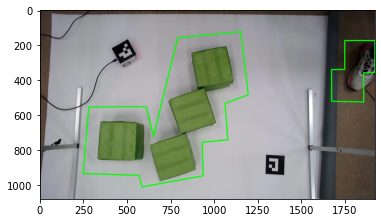

In [10]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for vertice in vertices:
    cv2.drawContours(img_rgb, [vertice], -1, (0, 255, 0), 5)
plt.imshow(img_rgb)

## Path planning  <a class="anchor" id="planning"></a>
The contour detection allowed us to pinpoint the location of all of the obstacles. Once they were detected, their sizes were virtually increased in order to ensure that the Thymio would not collide with them during navigation. </br> The vertices of all of the enlarged obstacles were then compiled and used as the input for the path planning algorithm. The idea was to draw the shortest path from the Thymio’s initial position, through the obstacle vertices, and end at the goal position. </br> This was achieved by translating all vertices into a list of nodes, and then testing the positional cost of each node relative to the goal position. </br>After the cost of each node was calculated, a path which minimized positional cost over all of the nodes was identified. </br> </br> 
We used **Dijkstra** in this case as it is  **complete** meaning that if a solution existed it would find it. Additionally, there were no clear heuristics we could use to find the goal more quickly, as we were in a free moving environment, and it was much lighter computationally in the case of a kidnapping. </br>  

In [11]:
class Node:
    def __init__(self,position,id,type="node",neighbours=[],obstacle_id=None):
        #properties
        self.position = position #[x,y]
        self.id = id #we need ids to allow the nodes to refer to each other, the id corresponds to the index of this node in the node list of the planner
        self.type = type #types: "node", "start", "end"
        
        self.point2d = Point(*tuple(position))
        self.obstacle_id = obstacle_id

        #connections
        self.access_cost = 0
        self.access_node = 0 #id of node from which we can access this node with the lowest cost
        self.visibility_list = neighbours[:] #contains the ids of the nodes visible by this node

    def print(self):
        print("== Node {0} : Position:{1} - Type:{2} - Cost:{4} with node {5} - Visibility:{3} - Obstacle: {6}".format(self.id,self.position,self.type,self.visibility_list,self.access_cost,self.access_node,self.obstacle_id))
    
    def plot(self,color="green"):
        plt.scatter(*tuple(self.position),color=color)

class Planner:
    def __init__(self):
        self.list_nodes = []
        self.list_obstacles = [] #list of sympy.Polygon that defines the obstacles

        self.start_node_id = None
        self.end_node_id = None
    
    def add_node(self,position,type="node",neighbours=[],obstacle_id=None):
        self.list_nodes.append(Node(position,len(self.list_nodes),type,neighbours,obstacle_id))

    def set_start(self,position):
        if self.start_node_id == None:
            self.start_node_id = len(self.list_nodes)
            self.add_node(position,"start",[])
        else:
            self.list_nodes[self.start_node_id] = Node(position,id=self.start_node_id,type="start",neighbours=[],obstacle_id=None)
            self.update_visibility_node(planner.start_node_id)

    def set_end(self,position):
        if self.end_node_id == None:
            self.end_node_id = len(self.list_nodes)
            self.add_node(position,"end",[])
        else:
            self.list_nodes[self.end_node_id] = Node(position,id=self.end_node_id,type="end",neighbours=[],obstacle_id=None)

    #add nodes and obstacle polygon from vertices
    def add_obstacle(self,list_vertices):
        current_obstacle_id = len(self.list_obstacles)
        first_id = len(self.list_nodes)
        last_id = len(self.list_nodes) + len(list_vertices)-1
        #add first node of obstacle
        self.add_node(list_vertices[0][0],neighbours=[last_id,first_id+1],obstacle_id=current_obstacle_id)
        for i in range(1,len(list_vertices)-1):
            self.add_node(list_vertices[i][0],neighbours=[len(self.list_nodes)-1,len(self.list_nodes)+1],obstacle_id=current_obstacle_id)
        #add last node of obstacle
        self.add_node(list_vertices[-1][0],neighbours=[last_id-1,first_id],obstacle_id=current_obstacle_id)
        #add the obstacle polygon
        self.list_obstacles.append(Polygon(*tuple([self.list_nodes[i].point2d for i in range(first_id,last_id+1)])))

    #tells the planner that two nodes can't see each other anymore
    def block_visibility(self,node_a_id,node_b_id):
        if node_a_id in self.list_nodes[node_b_id].visibility_list:
            self.list_nodes[node_b_id].visibility_list.remove(node_a_id)
        if node_b_id in self.list_nodes[node_a_id].visibility_list:
            self.list_nodes[node_a_id].visibility_list.remove(node_b_id)

    #updates the visibility_list of one node
    def update_visibility_node(self,node_id,is_vertices=False):
        self.list_nodes[node_id].visibility_list = []
        for _node_id in range(len(self.list_nodes)):
            if node_id in self.list_nodes[_node_id].visibility_list:
                self.list_nodes[_node_id].visibility_list.remove(node_id)
        for node_b in self.list_nodes:
            if node_b.id != node_id:
                visibility_line = Segment(self.list_nodes[node_id].point2d,node_b.point2d)
                visible = True
                optimized_obs_id = [i for i in range(len(self.list_obstacles))]
                if node_b.obstacle_id != None:
                    optimized_obs_id[0],optimized_obs_id[node_b.obstacle_id] = node_b.obstacle_id, 0
                for obs_id in optimized_obs_id:
                    n_inter = len(self.list_obstacles[obs_id].intersection(visibility_line))
                    if n_inter > 1:
                        visible = False
                        break
                if visible:
                    self.list_nodes[node_id].visibility_list.append(node_b.id)
                    if not (node_id in node_b.visibility_list):
                        node_b.visibility_list.append(node_id)
                else:
                    if node_id in node_b.visibility_list:
                        node_b.visibility_list.remove(node_id)
    
    #updates the visibility_list of all the nodes, this is a computer intensive function
    def update_visibility_all(self,first_time=True):
        if not first_time:
            for node in self.list_nodes:
                node.visibility_list = []
        for node_a in self.list_nodes:
            for node_b in self.list_nodes[node_a.id+1:]:
                if not node_b.id in node_a.visibility_list:
                    visibility_line = Segment(node_a.point2d,node_b.point2d)
                    visible = True
                    for obs_id in range(len(self.list_obstacles)):
                        inter = self.list_obstacles[obs_id].intersection(visibility_line)
                        if not first_time:
                            inter = [obj for obj in inter if type(obj) != Segment] #allows points of same side to see each other
                        n_inter = len(inter)
                        test = str(self.list_obstacles[obs_id].intersection(visibility_line))
                        if node_a.obstacle_id == node_b.obstacle_id and node_a.obstacle_id == obs_id:
                            if n_inter > 2:
                                visible = False
                                break
                            elif self.list_obstacles[obs_id].encloses_point(visibility_line.midpoint):
                                visible = False
                                break
                        elif n_inter > 1:
                            visible = False
                            break
                    if visible:
                        node_a.visibility_list.append(node_b.id)
                        node_b.visibility_list.append(node_a.id)

    #computes the access_cost and access_node from the starting node, uses the Dijksrat algorithm
    def update_cost(self):
        #Reset cost of each node
        for _node_id in range(len(self.list_nodes)):
            self.list_nodes[_node_id].access_cost = 0
        current_nodes_id = [self.start_node_id]
        timeout = 0 #for safety
        while (len(current_nodes_id) > 0) and (timeout < 100):
            timeout += 1
            next_nodes_id = []
            for id_base in current_nodes_id:
                for id_target in self.list_nodes[id_base].visibility_list:
                    cost = round(float(self.list_nodes[id_base].point2d.distance(self.list_nodes[id_target].point2d) + self.list_nodes[id_base].access_cost),2)
                    if (self.list_nodes[id_target].access_cost > cost) or ((self.list_nodes[id_target].access_cost == 0) and (self.list_nodes[id_target].type !="start")):
                        self.list_nodes[id_target].access_cost = cost
                        self.list_nodes[id_target].access_node = id_base
                        next_nodes_id.append(id_target)
            current_nodes_id = list(set(next_nodes_id[:])) #remove duplicate ids

    #returns the shortest path (list of coordinates)
    def get_path(self):
        path_ids = [self.end_node_id]
        path = [self.list_nodes[self.end_node_id].position]
        current_id = self.end_node_id
        while self.list_nodes[current_id].access_node != self.start_node_id:
            next_node_id = self.list_nodes[current_id].access_node
            path_ids.append(next_node_id)
            path.append(self.list_nodes[next_node_id].position)
            current_id = next_node_id
        path_ids.append(self.start_node_id)
        path.append(self.list_nodes[self.start_node_id].position)
        path.reverse()
        return path, path_ids

    #adds the nodes of obstacles, adds polygons, computes visibility for each node
    def setup(self,obstacle_vertices,start_pos=None,end_pos=None):
        for _obstacle in obstacle_vertices:
            self.add_obstacle(_obstacle)
        if start_pos != None:
            self.set_start(start_pos)
        if end_pos != None:
            self.set_end(end_pos)
        self.update_visibility_all()
        self.update_cost()
        
    def plot(self):
        self.plot_polygons()
        self.plot_node(self.start_node_id)
        self.plot_node(self.end_node_id)
        self.plot_path()
        plt.show()

    def print(self):
        counter = 0
        for _node in self.list_nodes:
            _node.print()
            counter += 1
    
    def plot_path(self):
        path = self.get_path()
        x_axis = []
        y_axis = []
        for point in path:
            x_axis.append(point[0])
            y_axis.append(point[1])
        plt.plot(x_axis,y_axis)

    def plot_node(self,node_id):
        self.list_nodes[node_id].plot()

    def plot_polygons(self):
        for polygon in self.list_obstacles:
            x_axis = []
            y_axis = []
            for point in polygon.vertices:
                x_axis.append(point.x)
                y_axis.append(point.y)
            x_axis.append(x_axis[0])
            y_axis.append(y_axis[0])
            plt.plot(x_axis,y_axis)

    def plot_visibility(self,node_id):
        self.list_nodes[node_id].plot("red")
        for id in self.list_nodes[node_id].visibility_list:
            self.list_nodes[id].plot()
            plt.plot([self.list_nodes[node_id].position[0],self.list_nodes[id].position[0]],[self.list_nodes[node_id].position[1],self.list_nodes[id].position[1]],color="orange")


In [ ]:
planner = Planner()
planner.setup(vertices,center,goal_center)
path,path_ids = planner.get_path()


In [13]:
print(path)

[(458, 249), array([789, 158], dtype=int32), array([1151,  123], dtype=int32), (1347, 884)]


## Filtering <a class="anchor" id="kalman"></a>
### Kalman Filter
The Kalman filter estimates the state of the robot by processing a set of noisy measurements, and compares the measurements with a motion model. In our case the **state of the robot** is defined by the state vector position, angle, forward speed, angular speed.
Process noise measures the uncertainty in the true motion of the object from the chose motion model. </br> </br> 
Low process noise means that the filter ignores rapid deviations from the true trajectory and instead favors the model </br>
High process noise admits greater local deviations from the motion model but makes the filter too sensitive to noisy measurements </br>

Measurement noise helps inform the filter how much it should weigh the new measurements vs the current motion model
High measurments noise indicates measurements are inaccurate and causes filter to favor the existing motion model and react

Predicted state estimate : $ \hat{x}_{k|k-1} = f(\hat{x}_{k-1|k-1},u_k)$  </br> 
Predicted covariance estimate : $ P_{k|k-1}= F_k P_{k-1|k-1} F^T_k + Q_k$</br> 
Innovation or measurement residual: $\tilde{y}= z_k - h(\hat{x}_{k|k-1})$ </br> 
Innovation(or residual) covariance : $S_k=H_k P_{k|k-1}H^T_k+R_k$ </br> 
Near-optimal Kalman gain : $ K_k= P_{k|k-1}H_k^TS^{-1}_k$</br> 
Updated state estimate: $\hat{x}_{k|k}=\hat{x}_{k|k-1}+K_k\tilde{y}_k$ </br> 
Updated covariance estimate :$  P_{k|k}= ( I - K_kH_k) P_{k|k-1}$ </br> 
</br>  </br> 
$F_k= \frac{\partial f}{\partial x}\Big \rvert_{\hat{x}_{k-1|k-1},u_k}$
$H_k= \frac{\partial h}{\partial x}\Big \rvert _{\hat{x}_{k|k-1}}$

### Our State Model
We estimate the following states of the robot : position ($p_x$ and $p_y$ coordinates), orientation $\theta$, forward velocity of the robot $v$ and angular velocity $\omega$. We get the following motion model :  



$$
  \begin{bmatrix} x_{k+1} \\ y_{k+1} \\ \theta_{k+1} \\ v_{k+1} \\ \omega_{k+1} \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & v_{k}cos(\theta_k)dt & 0 \\ 0 & 1 & 0 & v_{k}sin(\theta_k)dt & 0 \\ 0 & 0 & 1 & 0 & dt \\ 0&0&0&1&0 \\ 0&0&0&0&1 \end{bmatrix} \begin{bmatrix} x_{k} \\ y_{k} \\ \theta_{k} \\ v_{k} \\ \omega_{k} \end{bmatrix}
$$
- Based on Thymio's dynamic model, we first calculate the predicted state estimate (a priori) from the previous state while taking into account some possible noise in the model (modelled by the  model noise covariance matrix Q) 
- Next we compare the predicted state with the measurements (while also taking account measurement noise with matrix R) and then compute an updated state estimate (a posteriori)
- Setting high model noise values in Q and low measurement noise values in R causes the filter to be more sensitive to measurements and deviate more from the model </br> </br>
![kalman](report_figures/kalmanrep.png)


### Sources : 
Explanation : https://www.mathworks.com/help/fusion/ug/tuning-kalman-filter-to-improve-state-estimation.html) </br>
Code : https://github.com/L42Project/Tutoriels/blob/master/Divers/tutoriel36/KalmanFilter.py </br>
Formulas : https://en.wikipedia.org/wiki/Extended_Kalman_filter </br>


In [15]:
def convertWheelSpeeds(speed_l,speed_r,speed_factor=0.51,axle_track=205):
    '''
    Function that takes the raw values of each motor angular speed and converts it into
    translation speed (in px/s) and rotation speed (rad/sec).

    Inputs: - speed_l: speed of left motor (no units, from Thymio measurements)
            - speed_r: speed of right motor (no units, from Thymio measurements)
            - speed_factor: tuned variable that converts Thymio speed measurements to speed in px/s
            - axle_track: distance between the two Thymio wheels (in px, was slightly modified to get a better estimate for angular speed) 

    Output: - v  : The current forward velocity of the Thymio (in mm/s)
            - omega : The current angular velocity of the Thymio (in rad/s)(positive direction corresponding to that of the camera frame)
    '''

    v = 0.5*(speed_l + speed_r) / speed_factor
    omega = (speed_l - speed_r) / (0.5*axle_track*speed_factor)
    
    return v, omega
    

In [16]:
'''
Extended Kalman Filter class

Code modified from https://github.com/L42Project/Tutoriels/blob/master/Divers/tutoriel36/KalmanFilter.py
Comments describing Kalman Filter taken from https://stackoverflow.com/questions/74318200/how-to-tune-extended-kalman-filter-on-pykalman

Example of instance: KF=KalmanFilter(0.03333, [0, 0, 0, 0, 0]) (dt = 0.033 is the time between each measurement, x_ini = [0, 0, 0, 0, 0] is the initial state)

For update() function : takes as input the measurement vector z
z[0:2] are the measurements from the camera (px, py, orientation)
z[3:4] are the measurements from the Thymio (forward speed v and angular speed omega)

When Thymio position not found by camera -> z becomes 2x1 vector, with z[0:1] being the forward speed v and angular speed omega
'''


class KalmanFilter():
    def __init__(self, dt, x_ini):
        self.dt = dt

        # Initial State Vector
        self.x=np.matrix([[x_ini[0]], [x_ini[1]], [x_ini[2]], [x_ini[3]], [x_ini[4]]])
    

        # Initialize State Transition Matrix (Warning : changes with time -> updateFk())
        self.Fk=np.eye(5)

        # Initialize Measurement matrix H
        # Used to convert the predicted state estimate into predicted sensor measurements at time k.
        # In this case, H will be the identity matrix since the estimated state maps directly to state measurements data
        # H has the same number of rows as sensor measurements and same number of columns as states.
        self.H=np.eye(5)

        
        # State model noise covariance matrix Q
        # When Q is large, the Kalman Filter tracks large changes in
        # the sensor measurements more closely than for smaller Q.
        # Q is a square matrix that has the same number of rows as states.
        self.Q=np.diag([1, 1, 0.1, 1, 0.1])  
        

        # Sensor measurement noise covariance matrix R
        # Has the same number of rows and columns as sensor measurements.
        # If we are sure about the measurements, R will be near zero.
        self.coord_var = 0.01
        self.angle_var = 0.001
        self.speed_var = 1
        self.omega_var = 0.1
        
        self.R=np.diag([self.coord_var, self.coord_var, self.angle_var, self.speed_var, self.omega_var])

        self.P=np.eye(5)
        
    def updateFk(self):
        '''
        Function that updates the state transition matrix Fk
        '''
        
        self.Fk=np.matrix([[1.0, 0, 0, self.dt*math.cos(self.x[2]), 0],
                           [0, 1.0,  0, self.dt*math.sin(self.x[2]), 0],
                           [0, 0, 1.0, 0, self.dt],
                           [0, 0, 0, 1.0, 0],
                           [0, 0, 0, 0, 1.0]])
        self.Fk = self.Fk.astype(float)

    def predict(self):
        # Update Fk
        self.updateFk()
        # Predict the state estimate (A Priori) at time k based on the state estimate at time k-1
        self.x=np.dot(self.Fk, self.x)
        # Predict the state covariance estimate based on the previous covariance and some noise
        self.P=np.dot(np.dot(self.Fk, self.P), self.Fk.T)+self.Q
        return self.x

    def update(self, z, CameraAccessible = True): # z[0:2] corrpesonds to measurement of camera, z[3:4] corresponds to measurements of wheels
        
        if CameraAccessible:
            self.H=np.eye(5)
            
            self.R=np.diag([self.coord_var, self.coord_var, self.angle_var, self.speed_var, self.omega_var])
        else: # CAUTION : IF CAMERAACCESSIBLE = FALSE, Z IS A 2x1 VECTOR (z[0:1] are now measrurements from wheels)
            # Measurement matrix H (now only v and omega can be observed)
            self.H=np.matrix([[0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 1]])
            
            self.R=np.diag([self.speed_var, self.omega_var])
            
            
        # Compute Kalman gain
        S=np.dot(self.H, np.dot(self.P, self.H.T))+self.R
        inv_S = np.linalg.pinv(S.astype(float))
        K=np.dot(np.dot(self.P, self.H.T),inv_S)

        # Correction / innovation
        # Calculate an updated state estimate (A Posteriori) for time k
        self.x=self.x+np.dot(K, (z-np.dot(self.H, self.x)))
        # Update the state covariance estimate for time k
        I=np.eye(self.H.shape[1])
        self.P=(I-(K*self.H))*self.P


        return self.x

## Control <a class="anchor" id="cont"></a>
### Approach
Once the path is planned, the global navigation protocol begins. Both the angle and location of the Thymio with respect to the path are continuously updated in order to apply control. </br>
In fact, the angle of the Thymio with respect to the path is a function of its distance from the path.  </br>
The further the Thymio is away from the optimal path, the more aggressive the control input is. This manifests physically as a completely perpendicular return to the path when the Thymio is a large distance away. </br>
As the distance decreases, so does the angle between the Thymio and the path, until the difference in the angles converges to zero and the Thymio continues moving forward directly along the path. </br>
This control provides the framework for the global navigation process, and is only interrupted when a local obstacle is sensed or the Thymio reaches its goal. </br> </br>

### Advantages: 
- No need to time the movements (for example, sleep for a period t).
- Speed is set automatically based on Thymio's position.
- Lower margin of error compared to using timers in x directions

![Navigation](report_figures/navigation.png)

In [20]:
class TrajFollower:
    def __init__(self,dist_threshold,speed_offset=50,kp_ref_angle=0.02,kp_follow_angle = 100):
        self.dist_threshold = dist_threshold
        self.path_step = 0
        self.speed_offset = speed_offset
        self.kp_ref_angle = kp_ref_angle
        self.kp_follow_angle = kp_follow_angle
    
    def get(self,x,y,angle,path):
        traj_seg = Segment(Point(*tuple(path[self.path_step])),Point(*tuple(path[self.path_step+1])))
        traj_ray = Ray(Point(*tuple(path[self.path_step+1])),Point(*tuple(path[self.path_step])))
        robot_dot = Point(x,y)
        robot_ray = Ray(Point(*tuple(path[self.path_step+1])),robot_dot)
        error = traj_seg.distance(robot_dot)
        ref_angle = np.arctan((path[self.path_step][1]-path[self.path_step+1][1])/(path[self.path_step][0]-path[self.path_step+1][0]))
        if robot_ray.closing_angle(traj_ray) < 0:
            error = -error

        correction = self.kp_ref_angle*error
        correction = max(-np.pi/2, correction)
        correction = min(np.pi/2, correction)
        target_angle = ref_angle + correction

        angle_error = target_angle-angle
        speed_diff = self.kp_follow_angle*angle_error

        speed_left = self.speed_offset + speed_diff
        speed_right = self.speed_offset - speed_diff

        return speed_right, speed_left

    def incr_step(self):
        self.path_step += 1

    def reset_step(self):
        self.path_step = 0

    def get_step(self):
        return self.path_step

## Local Navigation/ obstacle avoidance <a class="anchor" id="obst"></a>

For the obstacle avoidance, and in order to be able to test it separately/ to not interfere with node if "run all" is pressed, we provide the implementation and test in a separate .py [file](src_cleaned/obstacle_avoidance.py), or refer to the loop in the run cell.
### Avoidance
**Input**: Value of horizontal proximity sensors of thymio </br>
**Output**: Maneuver to be performed by adjusting Motor speed depending on the value of the sensors, a flag if entering the obstacle avoidance state. </br> 
We decide in which direction and with what speed to perform the maneuver through a weighted sum over the the left sensors and the right sensors. </br> 
We give more importance to the centric edge sensors mainly sensor 1 and 3 marked in black in the figure below, as if they are triggered in a companion of 0 and 2 respectively, it indicates a larger obstacles than if only one sensor is triggered. </br> 
### Kidnapping: 
**Input**: Value of ground proximity sensors of thymio, a threshold </br>
**Output**: a flag to tell when thymio is kidnapped and when it is back on track  </br>
Get live position and trigger replanning after each case as the optimal path can no longer be the shortest distance to the goal </br> </br>
Note: In the main run, we use iteration counters to make decisions, should we do a replaning and pass from a state to another.



![thymio](report_figures/thymiosensors.png)

## Run the project <a class="anchor" id="run"></a>
This loop enables the execution of the project with all of its components together. Initially, we setup the camera and perform the initial planning that explores all the nodes first, then execute a loop untill we reach the goal. Here we use the proximity sensors/ states to perform the maneuvers and set the speeds accordingly in each state

In [21]:
'''
Main loop
'''
forward_speed = 0
angular_speed = 0

KF=KalmanFilter(0.033, [0, 0, 0, forward_speed, angular_speed])
traj_follower = TrajFollower(10,50,0.02,100)

### INITIALIZE CAMERA
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
fps = int(cap.get(5))

### Obstacle, goal and initial position detection
ret, img = camera.read()
center, radius, angle, thymio_detected = get_thymio_position(img, imgResult)
vertices, nb_obstacles, x_max, y_max = get_obstacle_position(img, 74, min_green = np.array([20, 100, 0]), max_green = np.array([45, 255, 125]))
goal_center, goal_radius, goal_detected = get_goal_position(img)

### PATH PLANNING
print('Planning Path...')
planner = Planner()
planner.setup(vertices,center,goal_center)
path,path_ids = planner.get_path()
print(path)
print(path_ids)


### MAIN LOOP
count = 0

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

speed_left = 0
speed_right = 0
count_kidnapped_iter  = 0
state_avoidance = False
state_goal_reached = False
counter_obstacle_cooldown = 0
thymio_kidnapped = False
# running infinite while loop so that
# program keep running until we close it
while not state_goal_reached:
    success, img = cap.read()
    imgResult = img.copy()
    
    thymioLoc, thymioRadius, thymioAngle, thymioDetected = get_thymio_position(img, imgResult)
    
    # KALMAN -------------------------------------------------------------------
    
    forward_speed, angular_speed = convertWheelSpeeds(get_var("motor_left_speed")[0],get_var("motor_right_speed")[0])
    
    KF.predict()
    if thymioDetected:
        z = np.array([thymioLoc[0],thymioLoc[1],thymioAngle, forward_speed, angular_speed])
        z = np.expand_dims(z, axis=-1)
    else:
        z = np.array([forward_speed, angular_speed]) 
        z = np.expand_dims(z, axis=-1)
    KF.update(z,thymioDetected)
   
    # KALMAN ----------------------------------------------------------------------
    count = count + 1

    #Path tracking ----------------------------------------------------------------
    x = KF.x.item(0)
    y = KF.x.item(1)
    angle = KF.x.item(2)
    
    #detect if obstacle or not
    prox = get_var("prox.horizontal")[0]
    delta_val = get_var("prox.ground.delta")[0][0]
   
    if delta_val < 100:
        thymio_kidnapped = True
        speed_left = 0
        speed_right = 0
    
    elif thymio_kidnapped:  
        count_kidnapped_iter += 1
        if count_kidnapped_iter > 40:     
            planner.set_start([x,y])
            planner.update_cost()
            path, path_ids = planner.get_path()
            traj_follower.reset_step()
            thymio_kidnapped = False
            count_kidnapped_iter = 0


    if not thymio_kidnapped: 
        if any([x>3700 for x in prox[1:4]]) or (prox[0] > 3900) or (prox[4] > 3900):
            counter_obstacle_cooldown = 0
            state_avoidance = True
            var_prox= np.array(prox)
            sum_right = prox[4] + 1.2*prox[3]
            sum_left = prox[0] + 1.2*prox[1]
            k_avoid = 1/300

            speed_diff = int(k_avoid*(sum_right-sum_left))
            
            speed_left = -speed_diff
            speed_right = speed_diff
        
        elif state_avoidance:
            if counter_obstacle_cooldown < 50:
                counter_obstacle_cooldown += 1
                speed_left = 100
                speed_right = 100
            else:
                set_var(motor_left_target = 0)
                set_var(motor_right_target = 0)
                counter_obstacle_cooldown = 0
                state_avoidance = False
                planner.block_visibility(path_ids[traj_follower.get_step()],path_ids[traj_follower.get_step()+1])
                planner.set_start([x,y])
                planner.update_cost()
                path, path_ids = planner.get_path()
                traj_follower.reset_step()
        
    #path following
    if not state_avoidance and not thymio_kidnapped:
        if Point(x,y).distance(Point(*tuple(path[traj_follower.get_step()+1]))) <= 10:
            if Point(x,y).distance(Point(*tuple(goal_center))) <= 20:
                set_var(motor_left_target = 0)
                set_var(motor_right_target = 0)
                state_goal_reached = True
                break
            traj_follower.incr_step()

        speed_right, speed_left = traj_follower.get(x,y,angle,path)
        
    
    
    set_var(motor_left_target = int(speed_left))
    set_var(motor_right_target = int(speed_right))

    # displaying output on Screen
        ### PLOTTING ON LIVE IMAGES
    cv2.circle(imgResult,goal_center, goal_radius,(255,0,0),5)
    for vertice in vertices:
        cv2.drawContours(imgResult, [vertice], -1, (0, 255, 0), 5)
    
    checkpoints = path
    for idx, checkpoint in enumerate(checkpoints):
        if idx > 0:
            start_point = (int(checkpoints[idx-1][0]) , int(checkpoints[idx-1][1]) )
            end_point = (int(checkpoints[idx][0]) , int(checkpoints[idx][1]) )
            cv2.line(imgResult, start_point, end_point, (255,0,255), 5)
        else:
            pass
    
    ### DRAW KALMAN POSITION AND ANGLE ESTIMATE ---------------------
    
    cv2.circle(imgResult, (int(KF.x[0]), int(KF.x[1])), 10, (255,0,255), 10)
    cv2.arrowedLine(imgResult, (int(KF.x[0]), int(KF.x[1])), (int( KF.x[0] + 70*math.cos(KF.x[2])  ),int( KF.x[1] + 70*math.sin(KF.x[2])  )), (255,125,0), 10)
    
    ### -------------------------------------------------------------
    
    ### DISPLAY LIVE CAMERA FEED
    cv2.imshow("Result", imgResult)
    
    c = cv2.waitKey(1)
    if c == 27 & 0xFF == ord('q'):
        cv2.destroyWindow("Result")
        break

Unchecked Raise(exc=Call(func=Name(id='IOError', ctx=Load()), args=[Constant(value='Cannot open webcam')], keywords=[]))
Planning Path...
[(458, 249), array([789, 158], dtype=int32), array([1151,  123], dtype=int32), (1347, 884)]
[22, 0, 1, 21]


In [ ]:
set_var(motor_left_target = 0)
set_var(motor_right_target = 0)

## Conclusion <a class="anchor" id="conc"></a>

Through this project, we were able to successfully implement and integrate our learning of the course. </br>
- Through Vision, we were able to detect the thymio, the initial obstacles and the goal, making the environment partially observable .
- Through Global navigation, we were able to calculate the shortest path from the thymio to the goal.
- Through Local navigation, we were able to navigate the thymio around initially unobserved objects during the control and update its state.
- Through filtering, we were able to estimate the position of thymio at each timestamp both with and without vision. </br> </br>
![coursecomp](report_figures/projectcomp.png)
</br>
Each team member was able to demonstrate not only the part he was assigned to but as well each tried to work and contribute in different aspects to the project. </br>

### Thymio made it to the goal !! Farewell 


## References  <a class="anchor" id="ref"></a>


**Main reference**: Course material of Basics of Mobile Robotics </br> </br>
Zhu, X., Lyu, S., Wang, X., & Zhao, Q. (2021). TPH-YOLOv5: Improved YOLOv5 Based on Transformer Prediction Head for Object Detection on Drone-captured Scenarios. arXiv. https://doi.org/10.48550/ARXIV.2108.11539 </br>
</br>
Sampathkrishna, A. (2022). ArUco Maker based localization and Node graph approach to mapping. arXiv. https://doi.org/10.48550/ARXIV.2208.09355